In [1]:
import numpy as np
import pandas as pd
import os
import glob
import pickle as pkl
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shutil

In [2]:
def parse_outs_to_dataframe(filename):
    input_text = open(filename).read()
    lines = input_text.split("\n")
    current_trial_group = None
    current_noise_level = None
    data = []
    
    for line in lines:
        if "Running trials for n =" in line:
            current_trial_group = tuple(map(int, re.findall(r'\d+', line)))
        elif "Cross validating alpha under noise level:" in line:
            current_noise_level = float(line.split()[-1])
        elif "Trial:" in line and current_trial_group and current_noise_level is not None:
            trial_info = re.findall(r'{.*?}', line)[0]
            trial_info = eval(trial_info)
            trial_info["Trial"] = int(line.split()[1])
            
            # Modified regular expression to handle scientific notation
            number_regex = r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?'
            
            trial_info["Lowest CV Error"] = float(re.findall(f'(?<=Lowest CV Error:  ){number_regex}', line)[0])
            trial_info["Training Error"] = float(re.findall(f'(?<=Training Error:  ){number_regex}', line)[0])
            trial_info["Testing Error"] = float(re.findall(f'(?<=Testing Error:  ){number_regex}', line)[0])
            trial_info["n"] = current_trial_group[0]
            trial_info["p"] = current_trial_group[1]
            trial_info["m"] = current_trial_group[2]
            trial_info["Noise Level"] = current_noise_level
            data.append(trial_info)
    
    df = pd.DataFrame(data)
    return df


In [5]:
out_dir = 'outputs/0720/'
out_files = glob.glob(out_dir + '*.out')
omp_out = []
bomp_out = []

for file_path in out_files:
    out_summary = parse_outs_to_dataframe(file_path)
    if 'best_bag' in out_summary.columns:
        bomp_out.append(out_summary)
    else:
        omp_out.append(out_summary)
omp_out_summary = pd.concat(omp_out).reset_index(drop=True)
bomp_out_summary = pd.concat(bomp_out).reset_index(drop=True)
omp_error_dataframe = (omp_out_summary[['n', 'p', 'm', 'Noise Level','Training Error', 'Testing Error']]).groupby(['n', 'p', 'm', 'Noise Level']).mean().reset_index()
bomp_error_dataframe = bomp_out_summary[['n', 'p', 'm', 'Noise Level','Training Error', 'Testing Error']].groupby(['n', 'p', 'm', 'Noise Level']).mean().reset_index()

In [6]:
# first we need to add prefixes to the column names of each dataframe
temp_omp_error_dataframe = omp_error_dataframe.copy().add_prefix('omp_')
temp_bomp_error_dataframe = bomp_error_dataframe.copy().add_prefix('bomp_')

# then we remove the prefix from the columns we will merge on
temp_omp_error_dataframe.rename(columns={'omp_n':'n', 'omp_p':'p', 'omp_m':'m', 'omp_Noise Level':'Noise Level'}, inplace=True)
temp_bomp_error_dataframe.rename(columns={'bomp_n':'n', 'bomp_p':'p', 'bomp_m':'m', 'bomp_Noise Level':'Noise Level'}, inplace=True)

# now we can merge
merged_df = pd.merge(temp_omp_error_dataframe, temp_bomp_error_dataframe, on=['n', 'p', 'm', 'Noise Level'], suffixes=('_omp', '_bomp'))

merged_df['testing_error_improvement'] = (merged_df['omp_Testing Error'] - merged_df['bomp_Testing Error'])/ merged_df['omp_Testing Error']
merged_df['training_error_improvement'] = (merged_df['omp_Training Error'] - merged_df['bomp_Training Error'])/ merged_df['omp_Training Error']


groups = merged_df.groupby(['n', 'p', 'm'])
list_of_groups = [groups.get_group(x) for x in groups.groups]

merged_df


,n,p,m,Noise Level,omp_Training Error,omp_Testing Error,bomp_Training Error,bomp_Testing Error,testing_error_improvement,training_error_improvement
0,300,500,10,0.02,0.015418,0.015201,0.000257,0.001435,0.905628,0.983322
1,300,500,10,0.04,0.016805,0.016448,0.000814,0.003755,0.771736,0.951582
2,300,500,10,0.06,0.018987,0.018522,0.001344,0.007577,0.590926,0.929221
3,300,500,10,0.08,0.021965,0.021421,0.003699,0.011308,0.472114,0.831612
4,300,500,10,0.10,0.025723,0.026213,0.003269,0.017836,0.319582,0.872916
5,300,500,20,0.02,0.044469,0.050262,0.000456,0.005468,0.891212,0.989753
6,300,500,20,0.04,0.045978,0.052411,0.000598,0.007908,0.849120,0.986998
7,300,500,20,0.06,0.048302,0.054397,0.000841,0.011419,0.790077,0.982591
8,300,500,20,0.08,0.051249,0.058109,0.001236,0.017309,0.702132,0.975880
9,300,500,20,0.10,0.054950,0.061757,0.002601,0.024606,0.601561,0.952666


In [7]:
merged_df[['n','p','m','Noise Level','testing_error_improvement','training_error_improvement']]

,n,p,m,Noise Level,testing_error_improvement,training_error_improvement
0,300,500,10,0.02,0.905628,0.983322
1,300,500,10,0.04,0.771736,0.951582
2,300,500,10,0.06,0.590926,0.929221
3,300,500,10,0.08,0.472114,0.831612
4,300,500,10,0.10,0.319582,0.872916
5,300,500,20,0.02,0.891212,0.989753
6,300,500,20,0.04,0.849120,0.986998
7,300,500,20,0.06,0.790077,0.982591
8,300,500,20,0.08,0.702132,0.975880
9,300,500,20,0.10,0.601561,0.952666


In [8]:
for group in list_of_groups:
    group.columns = group.columns.str.replace('Error', '')
    group.columns = group.columns.str.replace('_error', '')
    print(f"m = {group['m'].iloc[0]}")
    print(group.drop(columns=['n', 'p', 'm']).to_latex(index=False))

m = 10
\begin{tabular}{rrrrrrr}
\toprule
 Noise Level &  omp\_Training  &  omp\_Testing  &  bomp\_Training  &  bomp\_Testing  &  testing\_improvement &  training\_improvement \\
\midrule
        0.02 &       0.015418 &      0.015201 &        0.000257 &       0.001435 &             0.905628 &              0.983322 \\
        0.04 &       0.016805 &      0.016448 &        0.000814 &       0.003755 &             0.771736 &              0.951582 \\
        0.06 &       0.018987 &      0.018522 &        0.001344 &       0.007577 &             0.590926 &              0.929221 \\
        0.08 &       0.021965 &      0.021421 &        0.003699 &       0.011308 &             0.472114 &              0.831612 \\
        0.10 &       0.025723 &      0.026213 &        0.003269 &       0.017836 &             0.319582 &              0.872916 \\
\bottomrule
\end{tabular}

m = 20
\begin{tabular}{rrrrrrr}
\toprule
 Noise Level &  omp\_Training  &  omp\_Testing  &  bomp\_Training  &  bomp\_Testing  &  te

/var/folders/r9/cr3fkwq558n9mv4z9n1c01k00000gn/T/ipykernel_69990/3533740765.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(group.drop(columns=['n', 'p', 'm']).to_latex(index=False))
/var/folders/r9/cr3fkwq558n9mv4z9n1c01k00000gn/T/ipykernel_69990/3533740765.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(group.drop(columns=['n', 'p', 'm']).to_latex(index=False))


In [10]:
# OMP_logs = glob.glob('outputs/0719/OMP*.pkl')
BOMP_logs = glob.glob('outputs/0720/BOMP*.pkl')

lists_of_K_error_under_best_bag = []
for temp_BOMP_log in BOMP_logs:
    with open(temp_BOMP_log, 'rb') as f:
        single_npm = pkl.load(f)[0]
    single_npm_logs = single_npm['log']
    for temp_single_npm_log in single_npm_logs:
        temp_bag_k_error_matrix = pd.DataFrame(temp_single_npm_log['best_bag_k_error_matrix'])
        temp_bag_k_error_matrix.columns = ['Bag', 'K', 'Best Predictor Error']
        K_error_under_best_bag = temp_bag_k_error_matrix[['K','Best Predictor Error']].groupby('K').min().reset_index()
        K_error_under_best_bag['noise_level'] = temp_single_npm_log['noise_level']
        K_error_under_best_bag['trial_id'] = temp_single_npm_log['trial']
        K_error_under_best_bag['n'] = single_npm['parameters']['n']
        K_error_under_best_bag['p'] = single_npm['parameters']['p']
        K_error_under_best_bag['m'] = single_npm['parameters']['m']
        lists_of_K_error_under_best_bag.append(K_error_under_best_bag)
current_total_K_error_under_best_bag = pd.concat(lists_of_K_error_under_best_bag).reset_index(drop=True)
current_total_K_error_under_best_bag

npm_K_error_under_best_bag_grouper = current_total_K_error_under_best_bag.groupby(['n', 'p', 'm'])
lists_of_K_error_under_best_bag_grouped = [npm_K_error_under_best_bag_grouper.get_group(x) for x in npm_K_error_under_best_bag_grouper.groups]



In [11]:
current_total_K_error_under_best_bag

,K,Best Predictor Error,noise_level,trial_id,n,p,m
0,1.0,0.018793,0.02,0,300,500,10
1,10.0,0.001378,0.02,0,300,500,10
2,20.0,0.001023,0.02,0,300,500,10
3,30.0,0.000905,0.02,0,300,500,10
4,40.0,0.000776,0.02,0,300,500,10
...,...,...,...,...,...,...,...
2095,160.0,0.002845,0.10,9,300,500,20
2096,170.0,5.285048,0.10,9,300,500,20
2097,180.0,7.404043,0.10,9,300,500,20
2098,190.0,761.624912,0.10,9,300,500,20


In [12]:
def create_viz_dir(viz_dir, erase_flag=False):
    if not os.path.exists(viz_dir):
        os.makedirs(viz_dir)
    date_str = datetime.now().strftime("%m%d")
    
    viz_dir = os.path.join(viz_dir, date_str)
    if erase_flag:
        try:
            shutil.rmtree(viz_dir)
        except:
            pass
    if not os.path.exists(viz_dir):
        os.makedirs(viz_dir)
    return viz_dir

In [15]:
def viz_for_k_under_best_bag(current_total_K_error_under_best_bag,viz_dir):
    n_val = current_total_K_error_under_best_bag['n'].unique()[0]
    p_val = current_total_K_error_under_best_bag['p'].unique()[0]
    m_val = current_total_K_error_under_best_bag['m'].unique()[0]


    # List of unique noise levels
    noise_levels = current_total_K_error_under_best_bag['noise_level'].unique()



    # Generate a separate plot for each noise level
    for noise_level in noise_levels:
        fig_title = f'Error vs K for Noise Level {noise_level} under best bag for n = {n_val}, p = {p_val}, m = {m_val}'
        # Subset the dataframe for the current noise level
        df_subset = current_total_K_error_under_best_bag[(current_total_K_error_under_best_bag['noise_level'] == noise_level)&(current_total_K_error_under_best_bag['K']<=170)]
        # Create a new figure
        plt.figure()

        # Use seaborn to create a lineplot with multiple lines (one for each trial)
        sns.lineplot(data=df_subset, x='K', y='Best Predictor Error', hue='trial_id', palette='tab10')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylim(0, 0.1)
        # Customize the title and labels
        plt.title(fig_title)
        plt.xlabel('K')
        plt.ylabel('Best Predictor Error')
        plt.savefig(os.path.join(viz_dir, fig_title + '.png'), bbox_inches='tight')
        # Display the plot
        plt.show()

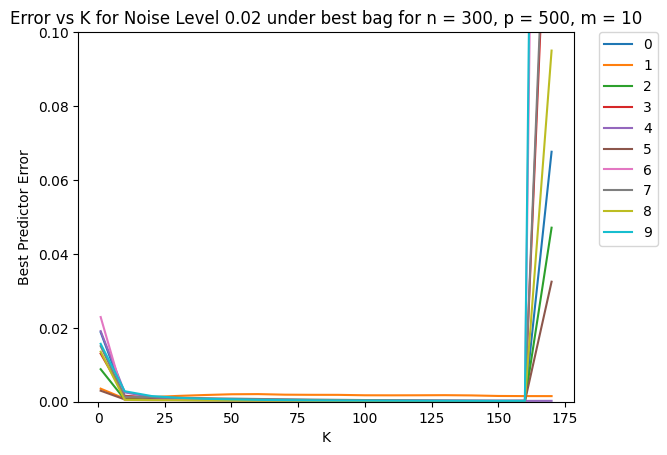

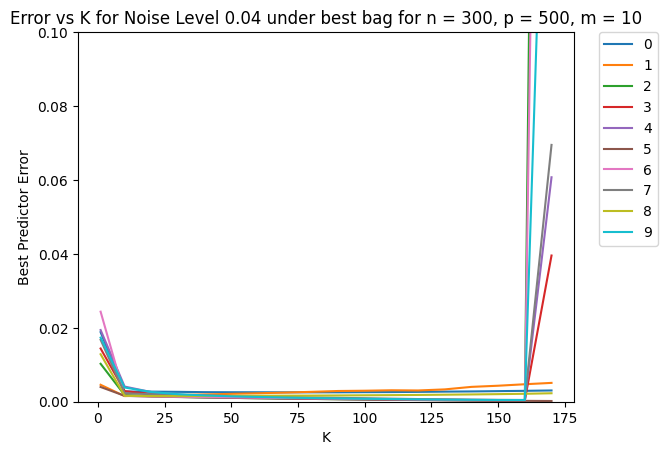

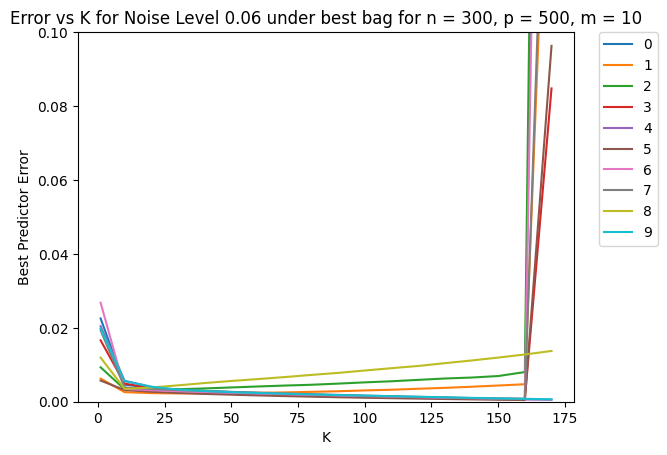

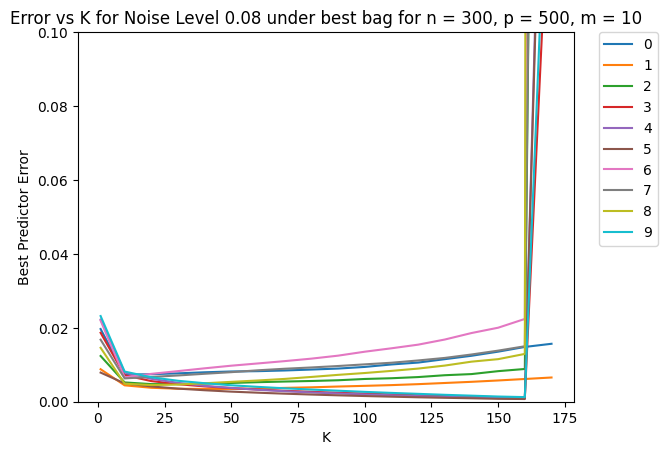

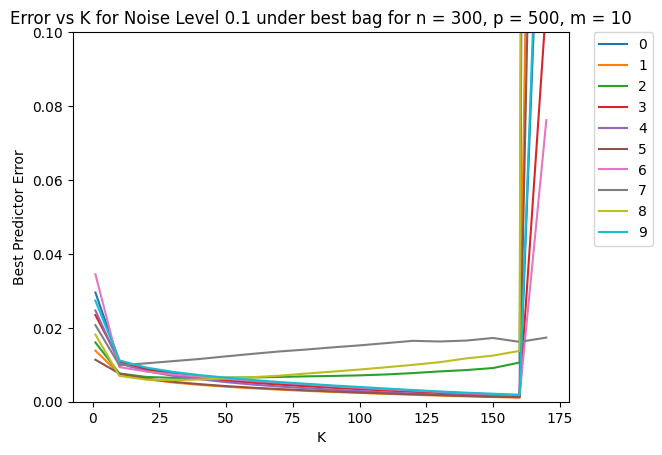

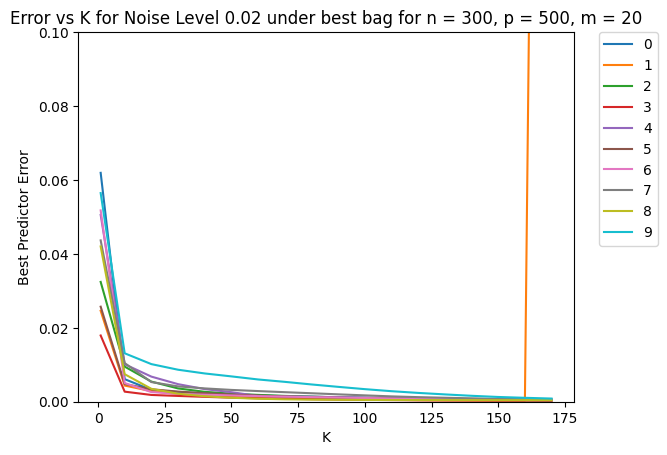

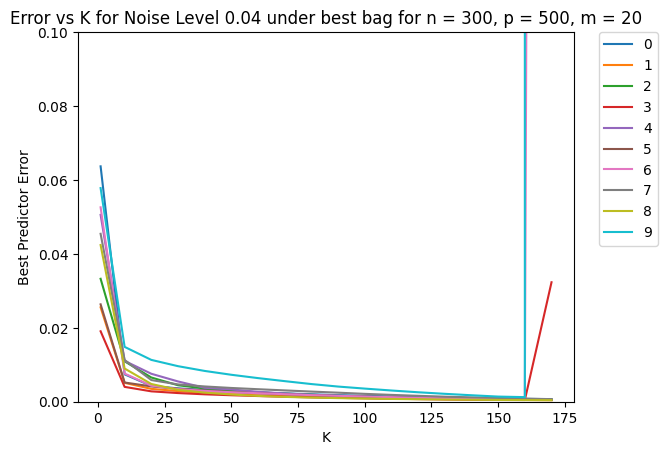

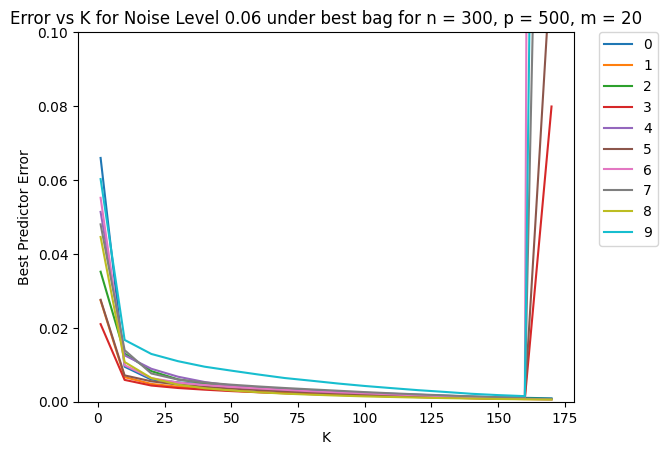

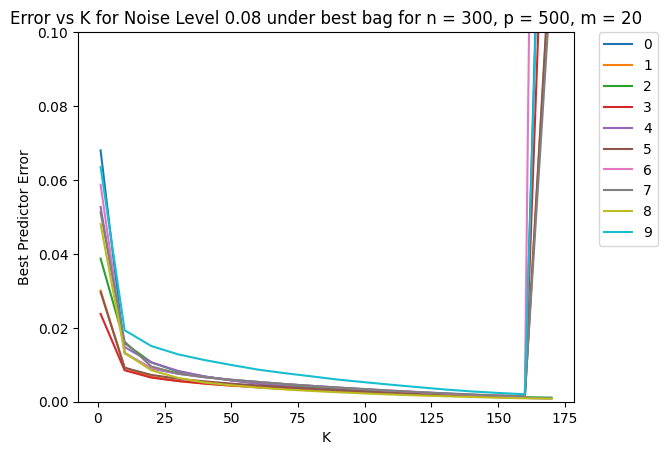

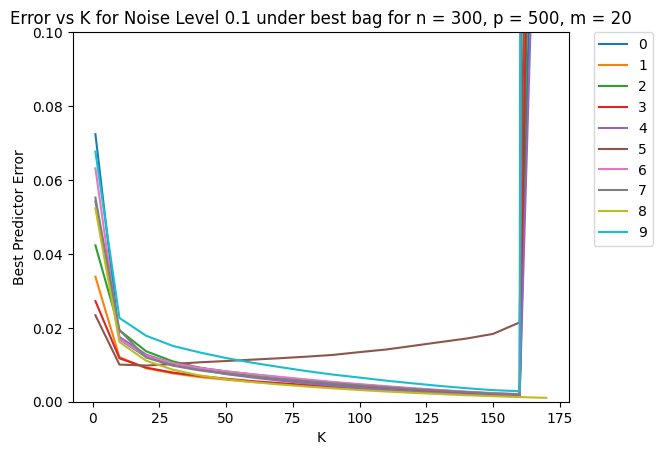

In [16]:
viz_dir = create_viz_dir('viz', erase_flag=True)
for list_of_K_error_under_best_bag_grouped in lists_of_K_error_under_best_bag_grouped:
    viz_for_k_under_best_bag(list_of_K_error_under_best_bag_grouped,viz_dir)

In [62]:
temp_single_npm_log.keys()

dict_keys(['noise_level', 'trial', 'cv_error_lst', 'lowest_cv_error', 'training_error', 'best_params', 'param_lst', 'testing_error', 'best_bag_k_error_matrix'])

In [63]:
single_npm_Bag_lst = single_npm['parameters']['fixed_params']['Bag_lst']
single_npm_K_lst  = single_npm['parameters']['fixed_params']['K_lst']